**Alzheimer's MRI Classification with CNN - 99.53% Accuracy**

Kaggle dataset containing 6400 MRIs belonging to 4 classes:
* Mild Demented
* Moderate Demented
* Non Demented
* Very Mild Demented

https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset/data

**PROJECT OVERVIEW**
1. Analyze dataset distribution
2. Generate TensorFlow dataset
3. Visualize data
4. Split into train, validation, and test datasets (80/10/10)
5. Construct CNN model
6. Train model and visualize training results
7. Evaluate model (99.53% accuracy)
8. Make predictions and generate classification report + confusion matrix

**SETUP**
* Import libraries 
* Test if GPU active

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential
import cv2
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

class colors:
    header = '\033[95m'
    blue = '\033[94m'
    cyan = '\033[96m'
    green = '\033[92m'
    yellow = '\033[93m'
    red = '\033[91m'
    bold = '\033[1m'
    underline = '\033[4m'
    end = '\033[0m'
    
#GPU QUERY
if tf.test.gpu_device_name():
    print('GPU active, ', tf.config.experimental.list_physical_devices('GPU'))
else:
    print('GPU not active')

GPU not active


**DATASET ANALYSIS**
* I have 4 subfolders in my Dataset directory, one for each label.
* First I analyze the image distribution and the image resolutions.

Searching for images in folder: Dataset...

Found subfolder: Mild_Demented
 -> Contains 896 images and 0 non-image files.

Found subfolder: Moderate_Demented
 -> Contains 64 images and 0 non-image files.

Found subfolder: Non_Demented
 -> Contains 3200 images and 0 non-image files.

Found subfolder: Very_Mild_Demented
 -> Contains 2240 images and 0 non-image files.


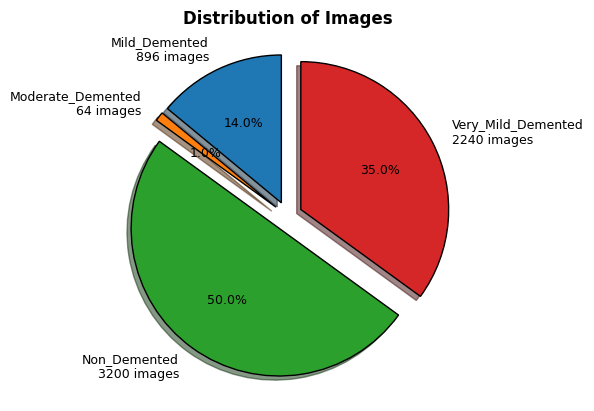

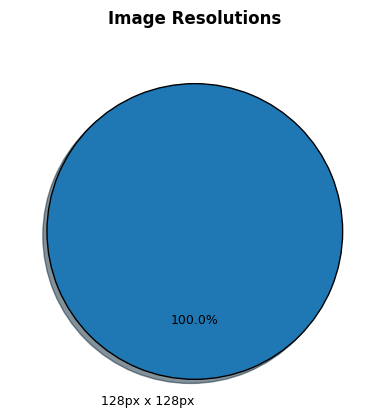

In [3]:
def image_counter(path):
        
    def get_img_res_string(path):
        img = cv2.imread(path)
        res = img.shape[:2]
        res_string=f"{res[0]}px x {res[1]}px"
        return res_string
        
    print(f'Searching for images in folder: {colors.green + colors.bold}{os.path.basename(path)}{colors.end}...')
    distribution = {}
    img_res_list_strings = []
            
    for root, dirs, files in os.walk(path):
        for dir in dirs:
            dir_path = os.path.join(root,dir)
            img_count = 0
            not_count = 0
            
            for file in os.listdir(dir_path):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_count += 1
                    img_res_list_strings.append(get_img_res_string(os.path.join(dir_path,file)))
                else:
                    not_count += 1
                
            distribution[dir] = img_count
            print(f"\nFound subfolder: {colors.green}{dir}{colors.end}")
            print(f" -> Contains {colors.blue}{img_count}{colors.end} images and {colors.blue}{not_count}{colors.end} non-image files.")

    #IMG COUNT PIE CHART
    folders = list(distribution.keys())
    img_counts = list(distribution.values())
    labels = []
    for i in range(len(folders)): labels.append(f"{folders[i]}\n{img_counts[i]} images")
    
    plt.pie(img_counts, labels=labels, 
        explode=(0.1,)*len(folders), autopct='%1.1f%%', shadow=True, startangle=90, colors=None, 
        textprops={'fontsize': 9, "fontweight" : "regular", "color":"black"},  wedgeprops={'edgecolor':'black'} , labeldistance=1.15)   
    plt.title("Distribution of Images", size=12, fontweight="bold")
    plt.show()
    
    #IMG RES PIE CHART
    res_dict = Counter(img_res_list_strings)
    res_labels = list(res_dict.keys())
    res_counts = list(res_dict.values())    
    
    plt.pie(res_counts, labels=res_labels, 
        explode=(0.1,)*len(res_labels), autopct='%1.1f%%', shadow=True, startangle=90, colors=None, 
        textprops={'fontsize': 9, "fontweight" : "regular", "color":"black"},  wedgeprops={'edgecolor':'black'} , labeldistance=1.15)   
    plt.title("Image Resolutions", size=12, fontweight="bold")
    plt.show()
    
    return distribution    

path = 'C:/Users/kmccr/Desktop/Projects/Kaggle Alzheimer MRI Preprocessed Dataset/Dataset'
distribution = image_counter(path)

**GENERATE TENSORFLOW DATASET**
* This is the correct file structure for the "image_dataset_from_directory" function.
* I report some info about the dataset including the pixel vales. I will want to rescale them values from [0,255] to [0,1].

In [5]:
image_size = (128, 128)
batch_size = 32

data = tf.keras.utils.image_dataset_from_directory(path, 
                                                    batch_size=batch_size,
                                                    image_size=image_size,
                                                    shuffle=True,
                                                    seed=123)

#DISPLAY SOME INFO ABOUT THE DATASET
class_names = data.class_names
print('\nClass Labels: ', class_names)

for image_batch, labels_batch in data:
  print('Batch Shape = ', image_batch.shape)
  print('Batch Labels Shape = ', labels_batch.shape)
  first_image = image_batch[0]
  print('Min & Max Pixel Values = ', np.min(first_image), np.max(first_image))
  break

Found 6400 files belonging to 4 classes.

Class Labels:  ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
Batch Shape =  (32, 128, 128, 3)
Batch Labels Shape =  (32,)
Min & Max Pixel Values =  0.0 229.0


**VISUALIZE DATA**

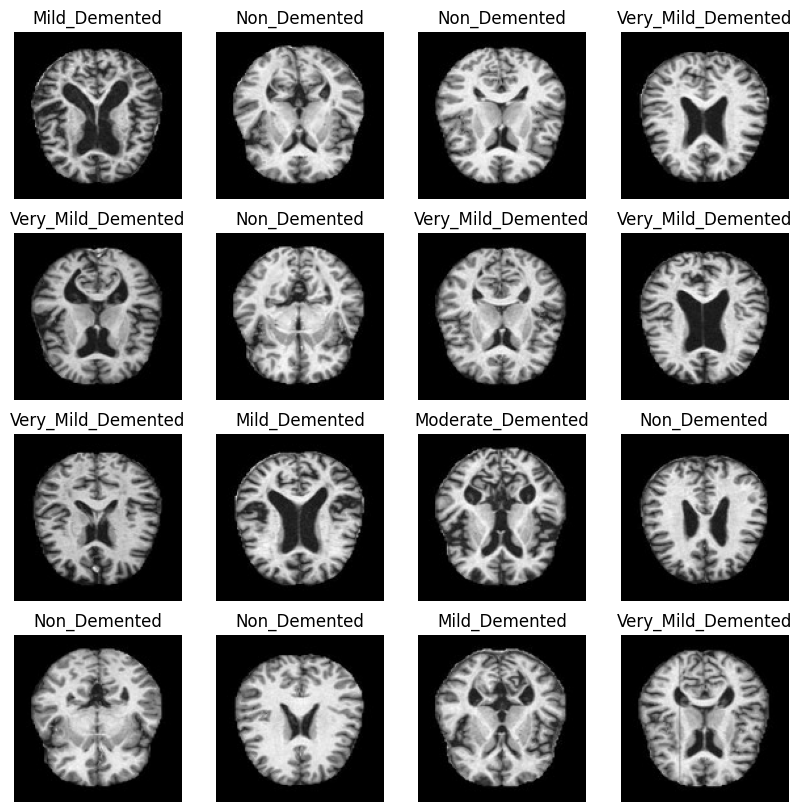

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(class_names[labels[i]]) # USE CLASS_NAMES TO GRAB LABEL
        plt.axis("off")

**SPLIT INTO TRAIN, VALIDATION, AND TEST DATASETS (80/10/10)**

In [8]:
def train_val_test_split(data, train_size, val_size, test_size):
    shuffled = data #data.shuffle(len(data), seed=123, reshuffle_each_iteration=False)
    
    num_train = int(len(data)*train_size)
    num_val = int(len(data)*val_size)
    num_test = int(len(data)*test_size)
    
    train_ds = shuffled.take(num_train)
    val_ds = shuffled.skip(num_train).take(num_val)
    test_ds = shuffled.skip(num_train+num_val).take(num_test)
    
    return train_ds, val_ds, test_ds
    
train_ds, val_ds, test_ds = train_val_test_split(data, .8 , .1, .1)

print(f'Training dataset contains {colors.blue}{len(train_ds)*batch_size}{colors.end} images.')
print(f'Validation dataset contains {colors.blue}{len(val_ds)*batch_size}{colors.end} images.')
print(f'Test dataset contains {colors.blue}{len(test_ds)*batch_size}{colors.end} images.')

Training dataset contains 5120 images.
Validation dataset contains 640 images.
Test dataset contains 640 images.


**CONSTRUCT CNN MODEL**

In [9]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_size[0], image_size[1], 3)), #RESCALE PIXEL VALUES FROM [0:255] TO [0:1]
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

**TRAIN MODEL**

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=15
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/15


160/160 [==============================] - 10s 62ms/step - loss: 0.9660 - accuracy: 0.5361 - val_loss: 0.8065 - val_accuracy: 0.6438
Epoch 2/15
160/160 [==============================] - 10s 64ms/step - loss: 0.7295 - accuracy: 0.6773 - val_loss: 0.6103 - val_accuracy: 0.7266
Epoch 3/15
160/160 [==============================] - 11s 67ms/step - loss: 0.4482 - accuracy: 0.8154 - val_loss: 0.3252 - val_accuracy: 0.8672
Epoch 4/15
160/160 [==============================] - 11s 68ms/step - loss: 0.2195 - accuracy: 0.9203 - val_loss: 0.1954 - val_accuracy: 0.9234
Epoch 5/15
160/160 [==============================] - 12s 74ms/step - loss: 0.1210 - accuracy: 0.9568 - val_loss: 0.1356 - val_accuracy: 0.9531
Epoch 6/15
160/160 [==============================] - 11s 70ms/step - loss: 0.0546 - accuracy: 0.9846 - val_loss: 0.1318 - val_accuracy: 0.9547
Epoch 7/15
160/160 [==============================] - 12s 73ms/step - loss: 0.0239 - accuracy: 0.9937 - val_loss: 0.0581 - val_accuracy: 0.9828
Epo

**VISUALIZE TRAINING RESULTS**

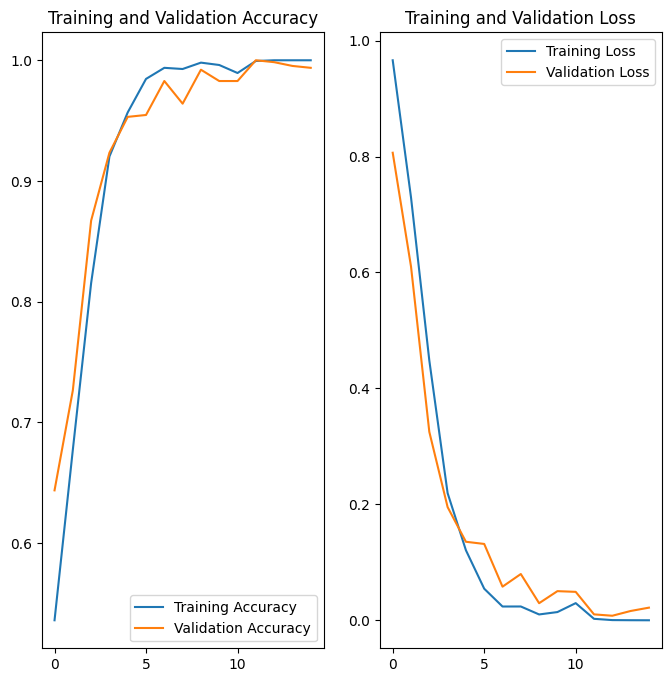

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

#PLOT ACCURACY
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#PLOT LOSS
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**EVALUATE MODEL ON TEST DATASET**

In [49]:
loss, accuracy = model.evaluate(test_ds)

print(f'\n Model accuracy = {colors.blue}{(accuracy*100):0.2f}%{colors.end}')

20/20 [==============================] - 1s 17ms/step - loss: 0.0191 - accuracy: 0.9953

 Model accuracy = 99.53%


**MAKE PREDICTIONS ON TEST DATASET**
* I generate a classification report and a confusion matrix to visualize prediction accuracy.

                    precision    recall  f1-score   support

     Mild_Demented       0.99      1.00      0.99        84
 Moderate_Demented       1.00      1.00      1.00         7
      Non_Demented       1.00      1.00      1.00       318
Very_Mild_Demented       1.00      1.00      1.00       231

          accuracy                           1.00       640
         macro avg       1.00      1.00      1.00       640
      weighted avg       1.00      1.00      1.00       640



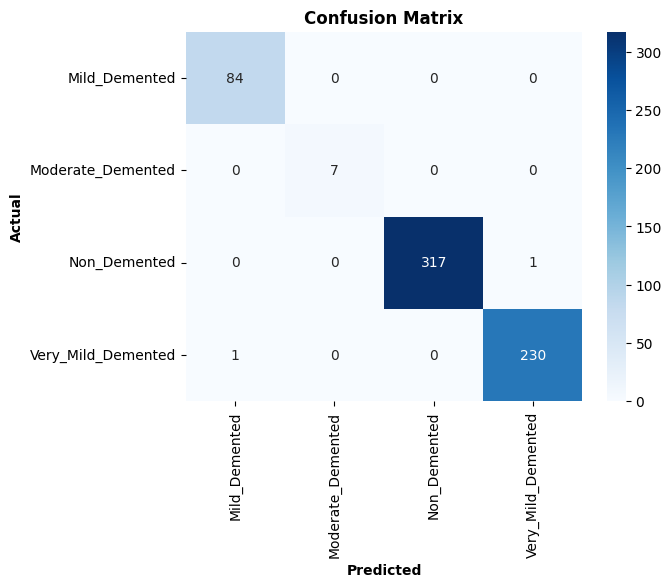

In [40]:
def predict_on(test_ds):
    predictions = []
    actuals = []
    
    for X, y in test_ds.as_numpy_iterator():
        pred = model.predict(X,verbose=0)
        prediction = np.argmax(pred, axis=1)
        predictions.extend(prediction)
        actuals.extend(y)
    
    #GENERATE CLASSIFICATION REPORT - SKLEARN
    print(classification_report(actuals, predictions, target_names=class_names))
    
    #GENERATE CONFUSION MATRIX - SKLEARN, SEABORN
    c_matrix = confusion_matrix(actuals, predictions)
    c_matrix_df = pd.DataFrame(c_matrix, index=class_names, columns=class_names)    
    sns.heatmap(data=c_matrix_df, annot=True, cmap="Blues", fmt="g")
    plt.title("Confusion Matrix", fontweight="bold")
    plt.xlabel("Predicted", fontweight="bold")
    plt.ylabel("Actual", fontweight="bold")
    plt.show()

    return np.array(predictions), np.array(actuals)

    
predictions, actuals = predict_on(test_ds)